# Summary

Exploratory data analysis of draft data (e.g. win rates)


# Introduction

I will explore the summary and draft data. This will look at the deck-level data and not get into
specific cards.


In [268]:
# | output: false
# Setup Notebook

import os


if os.path.basename(os.getcwd()) != "mtg-modeling":

    get_ipython().run_line_magic("run", '-i "../../scripts/notebook_header.py"')  # type: ignore

In [269]:
import pandas as pd
from tqdm.notebook import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import to_rgba, to_hex
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import time
import polars as pl
from datetime import datetime, timedelta
from PIL import Image

In [270]:
import src.plots.annotate as anno
import src.plots.symbols as symbols

In [271]:
SET_CODE = "BLB"

paths = {
    "processed": Path("data/processed/17lands/game_data/premier_draft"),
}
summary_file = paths["processed"] / f"{SET_CODE}_Game_PD_Summary.parquet"
game_file = paths["processed"] / f"{SET_CODE}_Game_PD_Games.parquet"
draft_file = paths["processed"] / f"{SET_CODE}_Game_PD_Drafts.parquet"
card_file = paths["processed"] / f"{SET_CODE}_Game_PD_Cards.parquet"

In [272]:
def blend_colors(color1, color2, ratio=0.5):
    blended_rgba = tuple(
        ratio * c1 + (1 - ratio) * c2
        for c1, c2 in zip(to_rgba(color1), to_rgba(color2))
    )
    return to_hex(blended_rgba)


# https://color.adobe.com/create/image
# https://pixels.com/featured/magic-the-gathering-colors-of-mana-aurora-uyainah.html
color_palette = {
    "W": "#fffbd5",
    "U": "#aae0fa",
    "B": "#cbc2bf",
    "R": "#f9aa8f",
    "G": "#9bd3ae",
}

color_pairs = ["WU", "WB", "WR", "WG", "UR", "UG", "UB", "BG", "BR", "RG"]
for color_pair in color_pairs:
    color_palette[color_pair] = blend_colors(
        color_palette[color_pair[0]], color_palette[color_pair[1]]
    )

# Summary Data

Below is the summary data for the Bloomburrow Premier Draft data from 17Lands.

You can see we have data from 07-30 through 08-18.  
The average win rate for the 17Lands players is 54.7%, which indicates the user base is more highly
skilled than the average Arena draft player by a healthy margin.
The average number of turns is 8.9. This should be compared to other sets understand the speed of
this sets.
There is a total of 680,000 games played, with an average of 5.8 games per draft.
This set has 276 cards and the average number of basic lands used is 22.2.


In [273]:
df_summary = pl.scan_parquet(summary_file)
df_summary.collect()

first_game,last_game,max_games,win_rate,start_rate,n_games,n_mul,n_opp_mul,mean_turns,max_turns,min_turns,n_drafts,n_matches,mean_matches,n_games_per_draft,n_cards,max_card,mean_land,max_land,min_land
datetime[μs],datetime[μs],i64,f64,f64,u32,i64,i64,f64,i64,i64,u32,i64,f64,f64,i32,i64,f64,i32,i32
2024-07-30 15:41:04,2024-08-18 23:59:52,2,0.547108,0.500285,679966,92172,96719,8.88899,33,1,116804,680693,5.827651,5.821427,276,7,22.164273,37,11


In [274]:
df_draft = pl.scan_parquet(draft_file)

# Color Decks

Let's explore the color decks.

## Color Frequency

First I will look at the number of decks drafted for each color set. The 10 two-color decks are the
most frequent. The Bloomburrow set is design for 10 two-color animal tribes, so this aligns with
the design intent of the set. Mono-color and multi-color decks are much lest frequent.

The Black-Green _Squirrels: Forage_ decks and the White-Green _Rabbits: Go-Wide_ decks are by far the most
popular. Most decks using Blue are much less favored.

See @fig-all-color-frequency


In [275]:
colors = (
    df_draft.group_by("main_colors")
    .agg(pl.col("n_games").count().alias("len"))
    .sort(by="len", descending=True)
    .collect()
)
colors = colors.to_pandas()
colors["Number of Main Colors"] = colors["main_colors"].str.len()
colors["pct_splash"] = colors["len"] / colors["len"].sum()
colors = colors.sort_values(["Number of Main Colors", "len"], ascending=[True, False])

colors_ct = (
    colors.groupby("Number of Main Colors")
    .sum()
    .reset_index(drop=False)
    .sort_values(["Number of Main Colors"], ascending=[True])
)

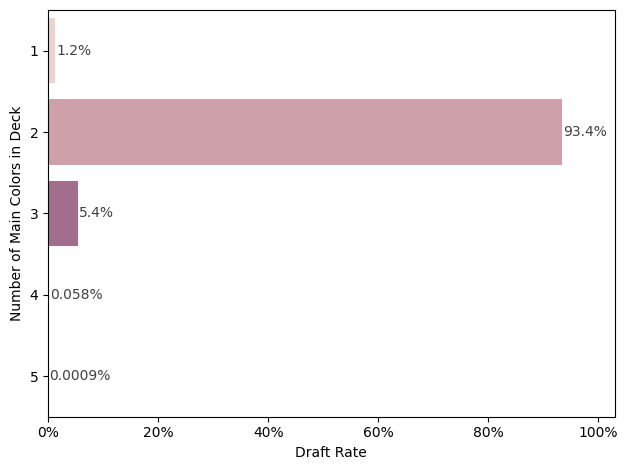

In [276]:
# | label: fig-n-color-frequency
# | fig-cap: "The rate at which the drafted deck has a given number of main colors."

g = sns.barplot(
    data=colors_ct,
    x="pct_splash",
    y="Number of Main Colors",
    hue="Number of Main Colors",
    orient="h",
    legend=False,
)

anno.annotate_bars()
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(
    xlabel="Draft Rate", ylabel="Number of Main Colors in Deck"
)

Since Bloomburrow is designed with 2-color tribal decks in mind, I will focus on these pairings. The most frequent drafted decks are Black-Green, White-Green, and Red-White. The least drafted are Blue-Black, Blue-Red and White-Blue.


In [277]:
colors["use_rate"] = colors["len"] / colors["len"].sum()
colors = colors.sort_values("use_rate", ascending=False)

two_colors = colors[colors["main_colors"].str.len() == 2]

use_rate_mu = two_colors["use_rate"].mean()

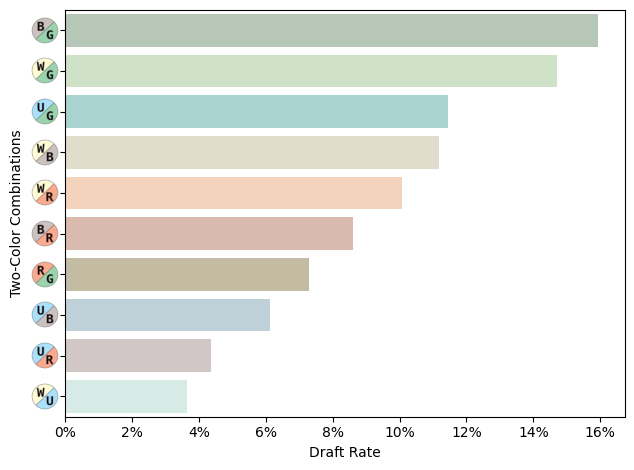

In [278]:
# | label: fig-n-two-color-frequency
# | fig-cap: "The rate at which the drafted deck is a given 2-color pair."

fig, ax = plt.subplots()
sns.barplot(
    data=two_colors,
    x="use_rate",
    y="main_colors",
    hue="main_colors",
    palette=color_palette,
    ax=ax,
)

symbols.add_tick_symbols()
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(xlabel="Draft Rate", ylabel="Two-Color Combinations")

Next let's look at the color composition of the decks. Below we can see that Green is the most
frequently drafted color, with Black and White also favored. Red and Blue are much less frequent.

The average draft use rate per component color is 40.0%.


In [279]:
for color in ["W", "U", "B", "R", "G"]:
    colors[color] = colors["main_colors"].apply(lambda x: True if color in x else False)

dfs = []
for color in ["W", "U", "B", "R", "G"]:
    sums = colors[["len", color]].groupby(color).sum()
    use_rate = (sums.loc[True] / sums.sum()).values[0]
    dfs.append(pd.DataFrame({"color": color, "use_rate": use_rate}, index=[0]))
df = pd.concat(dfs).sort_values("use_rate", ascending=False).reset_index(drop=True)

use_rate_mu = df["use_rate"].mean()

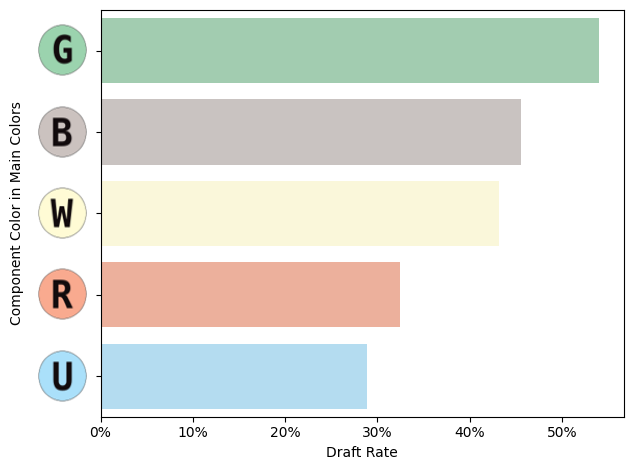

In [280]:
# | label: fig-component-color-frequency
# | fig-cap: "The rate at which the drafted deck contains a given color in the main deck colors."

fig, ax = plt.subplots()
sns.barplot(data=df, x="use_rate", y="color", hue="color", palette=color_palette, ax=ax)

symbols.add_tick_symbols()
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(
    xlabel="Draft Rate", ylabel="Component Color in Main Colors"
)

I next select the 4 decks with the largest absolute change in use between the start and end of the time period. The WG and WB decks have the largest increase in use, while the UR and WR decks have the largest decrease in use.


In [281]:
color_time = (
    (
        df_draft.filter(
            pl.col("main_colors").str.len_chars() == 2,
        )
        .group_by(pl.col("draft_time").dt.truncate("3d"), pl.col("main_colors"))
        .agg(
            pl.col("n_games").sum(),
            pl.col("n_wins").sum(),
        )
        .sort(by=["draft_time", "n_games"], descending=[False, True])
    )
    .with_columns(pl.col("draft_time") + timedelta(days=2))
    .collect()
    .to_pandas()
)

rank_time_sum = (
    color_time[["draft_time", "n_games"]].groupby(["draft_time"]).sum().reset_index()
)

color_time = color_time.merge(rank_time_sum, on="draft_time", suffixes=("", "_sum"))
color_time["rank_pct"] = color_time["n_games"] / color_time["n_games_sum"]

color_time_mean = (
    color_time[["draft_time", "n_wins", "n_games"]]
    .groupby("draft_time")
    .sum()
    .reset_index()
)
color_time_mean["win_rate"] = color_time_mean["n_wins"] / color_time_mean["n_games"]

end_mask = color_time["draft_time"] == color_time["draft_time"].max()
end_time = color_time.loc[end_mask]

start_mask = color_time["draft_time"] == color_time["draft_time"].min()
start_time = color_time.loc[start_mask]

diff_time = end_time.merge(start_time, on="main_colors", suffixes=("_end", "_start"))
diff_time["rank_diff"] = diff_time["rank_pct_start"] - diff_time["rank_pct_end"]
diff_time["abs_rank_diff"] = diff_time["rank_diff"].abs()
diff_time = diff_time.sort_values("abs_rank_diff", ascending=False)
diff_time[["abs_rank_diff", "main_colors"]]

color_decks = diff_time["main_colors"].head(4).to_list()
color_time = color_time.loc[color_time["main_colors"].isin(color_decks)]

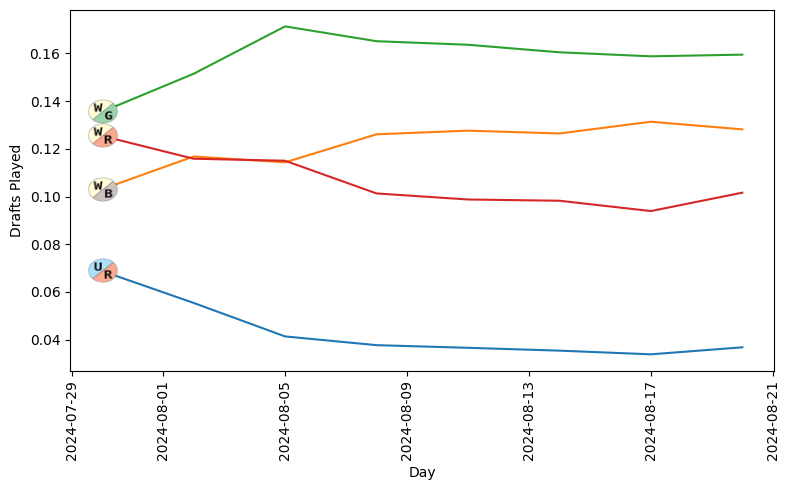

In [282]:
# | label: fig-color-freq-over-time
# | fig-cap: >
# |     "Frequency of Drafted Decks by Two-Color Pair: This figure shows the rate at which
# |     different two-color pairs are drafted, highlighting trends and preferences in deck selection
# |     over time."

plt.subplots(figsize=(8, 5))
g = sns.lineplot(
    data=color_time,
    x="draft_time",
    y="rank_pct",
    hue="main_colors",
    hue_order=color_decks,
    legend=False,
)

symbols.add_timeseries_symbols(
    data=color_time,
    x_col="draft_time",
    y_col="rank_pct",
    label_col="main_colors",
    loc=pd.to_datetime("2024-07-30"),
)
anno.set_axis_labels_and_show(xlabel="Day", ylabel="Drafts Played", rot_x=True)

## Color Win Rates

In addition to the use rate of the colors, I will also look at the win rates of the colors. First I calculate the weighted average win rate of 54.7%. As we saw in the summary section, this indicates that the 17Lands player base has a higher win rate than the general draft player base.

Below is a chart of the win rate for each color combination. There are some mono-color decks with high win rates, but have very low use rates, so the results may be circumstantial with a small sample size.


In [283]:
mean_win_rate = df_summary.collect().to_pandas()["win_rate"].values[0]
print(f"Average Win Percentage: {mean_win_rate:0.2%}")

Average Win Percentage: 54.71%


In [284]:
color_wins = (
    df_draft.group_by("main_colors")
    .agg(
        pl.col("n_games").sum(),
        pl.col("n_wins").sum(),
        pl.col("n_losses").sum(),
    )
    .sort(by="n_games", descending=True)
    .collect()
)
color_wins = color_wins.to_pandas()
color_wins["Number of Main Colors"] = color_wins["main_colors"].str.len()
color_wins["win_rate"] = color_wins["n_wins"] / color_wins["n_games"]
color_wins["loss_rate"] = color_wins["n_losses"] / color_wins["n_games"]
color_wins = color_wins.sort_values(
    ["Number of Main Colors", "win_rate"], ascending=[True, False]
)

color_wins_ct = (
    color_wins.groupby("Number of Main Colors")
    .sum()
    .reset_index(drop=False)
    .sort_values(["Number of Main Colors"], ascending=[True])
)
color_wins_ct["win_rate"] = color_wins_ct["n_wins"] / color_wins_ct["n_games"]
color_wins_ct["loss_rate"] = color_wins_ct["n_losses"] / color_wins_ct["n_games"]

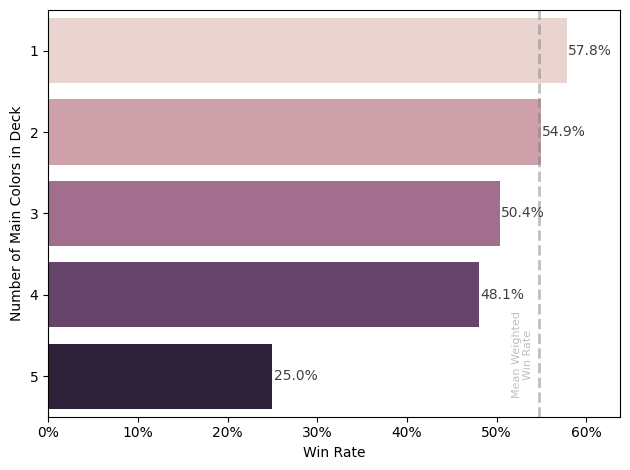

In [285]:
# | label: fig-n-color-wins
# | fig-cap: "The rate at which the drafted deck is a given 2-color pair."

g = sns.barplot(
    data=color_wins_ct,
    x="win_rate",
    y="Number of Main Colors",
    hue="Number of Main Colors",
    orient="h",
    legend=False,
)

anno.plot_vert_line(x=mean_win_rate, label="Mean Weighted\nWin Rate", offset=-0.03)
anno.annotate_bars()
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(xlabel="Win Rate", ylabel="Number of Main Colors in Deck")

Focusing on the 2-color decks, the Black-Red _Lizards: Opponents Lose Life_ is the highest win rate, but with a fairly low use rate. The White-Red _Rabbits: Go-Wide_ and Black-Green _Squirrels: Forage_ are the most popular decks and have high win rates.


In [286]:
color_mask = color_wins["main_colors"].str.len() == 2
two_color_wins = (
    color_wins.loc[color_mask]
    .sort_values("win_rate", ascending=False)
    .reset_index(drop=True)
)

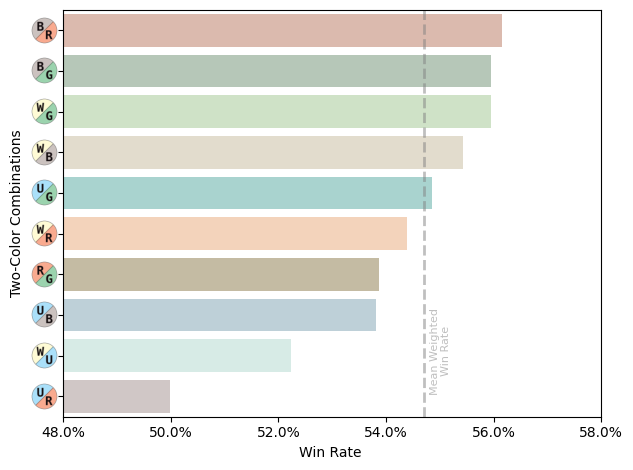

In [287]:
# | label: fig-n-two-color-wins
# | fig-cap: "The win rate for each 2-color pair."

g = sns.barplot(
    data=two_color_wins,
    x="win_rate",
    y="main_colors",
    hue="main_colors",
    palette=color_palette,
)
g.set(xlim=(0.48, 0.58))

anno.plot_vert_line(x=mean_win_rate, label="Mean Weighted\nWin Rate", offset=0.03)
symbols.add_tick_symbols()
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(xlabel="Win Rate ", ylabel="Two-Color Combinations")

Here is the win rates for the five primary colors, based on if they are a main color in a deck. For
example, the "B" results below are for Black win rates in decks suck as WB, BG, B, and UBR.

The average win rate for the data is 54.7%. The decks with Black perform the best, with a 55.2%
win rate. Decks with Green and White also perform well, with 55.0% and 54.8% respectively.
The decks with Red and Blue under-perform, with 53.8% and 53.2% win rate each.


In [288]:
for color in ["W", "U", "B", "R", "G"]:
    color_wins[color] = color_wins["main_colors"].apply(
        lambda x: True if color in x else False
    )

dfs = []

for color in ["W", "U", "B", "R", "G"]:
    agg = color_wins.groupby(color).sum()
    agg["win_rate"] = agg["n_wins"] / agg["n_games"]
    dfs.append(
        pd.DataFrame(
            {"component_color": color, "win_rate": agg.loc[True, "win_rate"]}, index=[0]
        )
    )

df = pd.concat(dfs)
df = df.sort_values("win_rate", ascending=False).reset_index(drop=True)

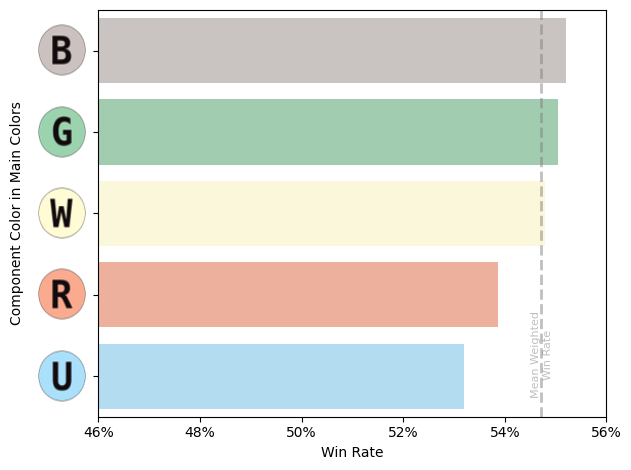

In [289]:
# | label: fig-component-color-wins
# | fig-cap: "The win rate for each given color in the main deck colors."

g = sns.barplot(
    data=df,
    x="win_rate",
    y="component_color",
    hue="component_color",
    palette=color_palette,
)
g.set(xlim=(0.46, 0.56))

symbols.add_tick_symbols()
anno.plot_vert_line(x=mean_win_rate, label="Mean Weighted\nWin Rate", offset=0.0016)
anno.set_labels_to_percent(precision=1)
anno.set_axis_labels_and_show(
    xlabel="Win Rate", ylabel="Component Color in Main Colors"
)

## Win Rate over Time

It is also interesting to see how the win rate for the two-color decks change over time. I selected the 4 decks with the largest absolute change in win rate between the start and end of the time period. The WR, WB, and WR decks start with high end rates, but slowly decrease over time. The UR deck starts with a low win rate, but increases over time.


In [291]:
color_time = (
    (
        df_draft.filter(
            pl.col("main_colors").str.len_chars() == 2,
        )
        .group_by(pl.col("draft_time").dt.truncate("7d"), pl.col("main_colors"))
        .agg(
            pl.col("n_games").sum(),
            pl.col("n_wins").sum(),
        )
        .sort(by=["draft_time", "n_games"], descending=[False, True])
    )
    .with_columns(pl.col("draft_time") + timedelta(days=5))
    .collect()
    .to_pandas()
)

color_time["win_rate"] = color_time["n_wins"] / color_time["n_games"]

color_time_mean = (
    color_time[["draft_time", "n_wins", "n_games"]]
    .groupby("draft_time")
    .sum()
    .reset_index()
)
color_time_mean["win_rate"] = color_time_mean["n_wins"] / color_time_mean["n_games"]

color_decks = diff_time["main_colors"].head(4).to_list()
color_time = color_time.loc[color_time["main_colors"].isin(color_decks)]

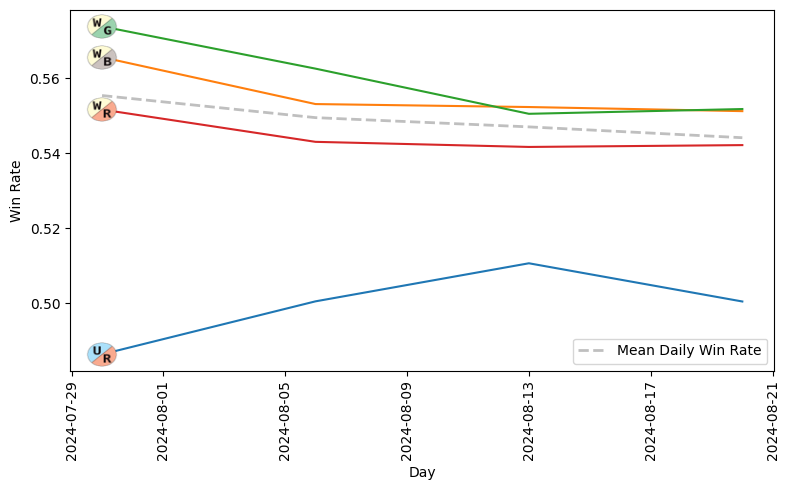

In [292]:
# | label: fig-color-wins-over-time
# | fig-cap: >
#   Win Rates of Drafted Decks by Two-Color Pair: This figure shows the win rate of
#   different two-color pairs, highlighting trends and preferences in deck performance
#   over time.

plt.figure(figsize=(8, 5))
g = sns.lineplot(
    data=color_time,
    x="draft_time",
    y="win_rate",
    hue="main_colors",
    hue_order=color_decks,
    legend=False,
)

symbols.add_timeseries_symbols(
    data=color_time,
    x_col="draft_time",
    y_col="win_rate",
    label_col="main_colors",
    loc=pd.to_datetime("2024-07-30"),
)

plt.plot(
    color_time_mean["draft_time"],
    color_time_mean["win_rate"],
    label="Mean Daily Win Rate",
    color="gray",
    linestyle="--",
    linewidth=2,
    alpha=0.5,
)

plt.legend(loc="lower right")
anno.set_axis_labels_and_show(xlabel="Day", ylabel="Win Rate", rot_x=True)

## Color Freq vs Win Rate

Let us now compare the use rate versus the win rate. If the player base is well calibrated to the
win rate with their selections.

Below we can see that most of the two-color decks fall in a straight line, with two outliers. The Blue-Red _Otters:
Non-creature Spells_ deck under-performs relative to its use rate. On the other hand, the Black-Red
_Lizards: Opponents Lose Life_ deck is a sleeper, with the highest win rates, but selected less than
the average two-color deck. The reason for this under-selection is that Red doesn't perform well
in general, so many drafters probably avoid drafting Red unless they get strong Black-Red cards
early. White, Green, and Black are perform well, so the BG, WG, and WB decks are easy to pivot among
in the draft.


In [293]:
paired_df = color_wins[
    ["main_colors", "win_rate", "loss_rate", "Number of Main Colors"]
]
colors["use_rate"] = colors["len"] / colors["len"].sum()
select_colors = colors[["main_colors", "use_rate"]]
paired_df = paired_df.merge(select_colors, on="main_colors")

color_mask = paired_df["Number of Main Colors"] == 2
paired_filtered_df = paired_df.loc[color_mask].reset_index(drop=True)

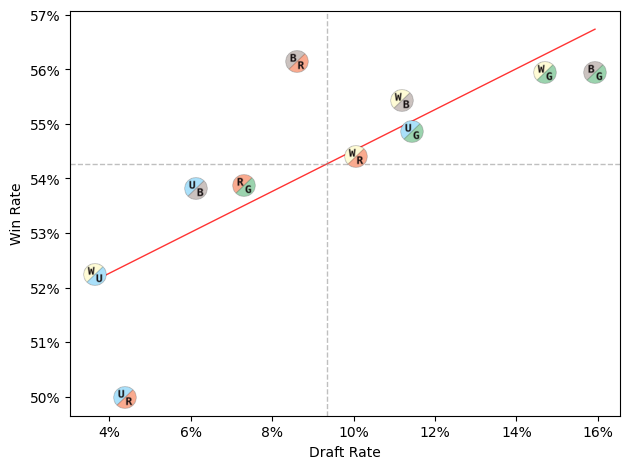

In [294]:
# | label: fig-wins-vs-freq-2color
# | fig-cap: "Win Rate vs Use Rate of 2-Color Draft Decks"

g = sns.regplot(
    data=paired_filtered_df,
    x="use_rate",
    y="win_rate",
    scatter=True,
    ci=None,
    line_kws={"color": "red", "linewidth": 1, "alpha": 0.8},
)

symbols.add_plot_symbols(
    data=paired_filtered_df,
    x_col="use_rate",
    y_col="win_rate",
    label_col="main_colors",
)

use_rate_mu = paired_filtered_df["use_rate"].mean()
win_rate_mu = paired_filtered_df["win_rate"].mean()
plt.axvline(use_rate_mu, color="gray", linestyle="--", linewidth=1, alpha=0.5)
plt.axhline(win_rate_mu, color="gray", linestyle="--", linewidth=1, alpha=0.5)

anno.set_labels_to_percent(axis="xy")
anno.set_axis_labels_and_show(xlabel="Draft Rate", ylabel="Win Rate")

## Wedges vs Shards

The MTG color theory has 5 wedges and 5 shards. The wedges are 3-color decks with a primary color and
its two allies. The shards are 3-color decks with a primary color and its two enemies. The conventional wisdom is that wedges are easier to draft than shards.

In @fig-wedge-vs-shards we can see that the shards have a slightly higher win rate, as well as a higher use rate.


In [356]:
wedges = ["WUG", "WUB", "WRG", "UBR", "BRG"]
shards = ["WUR", "WBG", "UBG", "URG", "WBR"]

color_wins["3_type"] = None
color_wins.loc[color_wins["main_colors"].isin(wedges), "3_type"] = "Wedge"
color_wins.loc[color_wins["main_colors"].isin(shards), "3_type"] = "Shards"
three_color_wins = color_wins.loc[color_wins["3_type"].notnull()]
three_color_wins = three_color_wins.groupby("3_type").sum()
three_color_wins["win_rate"] = three_color_wins["n_wins"] / three_color_wins["n_games"]

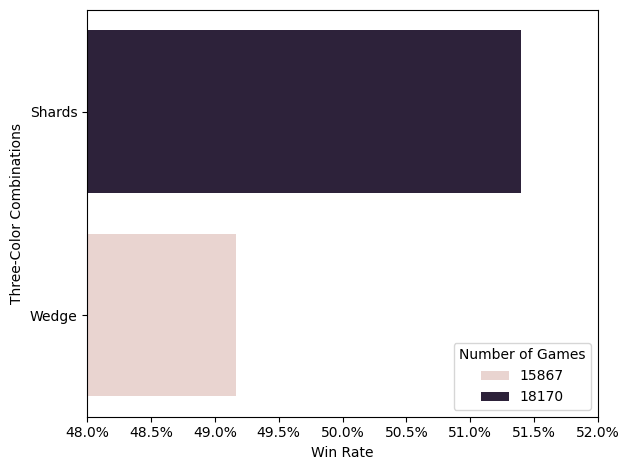

In [357]:
# | label: fig-wedge-vs-shards
# | fig-cap: "The win rate for shards versus wedges."


g = sns.barplot(
    data=three_color_wins,
    x="win_rate",
    y=three_color_wins.index,
    hue="n_games",
)
g.set(xlim=(0.48, 0.52))

anno.set_labels_to_percent()
anno.set_axis_labels_and_show(
    xlabel="Win Rate",
    ylabel="Three-Color Combinations",
    legend=True,
    legend_title="Number of Games",
)

# Opposing Player Colors

We have data on the opposing player colors. This is useful to understand the meta of the draft.  
For a given draft color combination, we can see the use rate by 17Lands players versus the use rate
opponents. Each draft color combination is also color coded if the win rate is above or below the
17Lands player base average win rate. A diagonal grey line is also added to show parity between the
use by the 17Lands players and the general player base.

In the chart blow looks at 2-color drafts. We can see that WG, BG, and UG are more favored by the 17Lands players and also
has a higher win rate. The UB color deck is more favored, but has a much lower win rate. The other
color pairs are on parity between the two player bases.


In [295]:
opp_colors = (
    df_draft.group_by("opp_colors")
    .len()
    .sort(by="len", descending=True)
    .collect()
    .to_pandas()
)

opp_colors["opp_use_rate"] = opp_colors["len"] / opp_colors["len"].sum()
opp_colors = opp_colors.rename(columns=({"len": "opp_len"}))
opp_colors = opp_colors.merge(
    paired_df, left_on="opp_colors", right_on="main_colors", how="left"
)
opp_colors["Above Avg Win Rate"] = opp_colors["win_rate"] > mean_win_rate

mask = opp_colors["main_colors"].str.len() == 2
opp_colors_filtered = opp_colors.loc[mask]

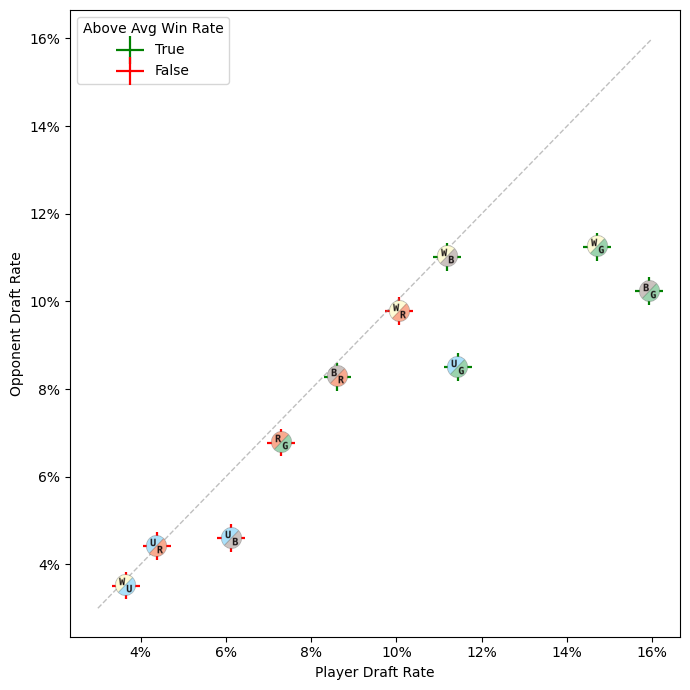

In [296]:
# | label: fig-player-vs-opp-freq-2color
# | fig-cap: "Use Rate of Players vs Opponents in 2-Color Draft Decks"

plt.figure(figsize=(7, 7))
g = sns.scatterplot(
    data=opp_colors_filtered,
    x="use_rate",
    y="opp_use_rate",
    hue="Above Avg Win Rate",
    marker="+",
    hue_order=[True, False],
    palette={True: "green", False: "red"},
    s=400,
)

plt.plot(
    [0.03, 0.16], [0.03, 0.16], color="gray", linestyle="--", linewidth=1, alpha=0.5
)

symbols.add_plot_symbols(
    data=opp_colors_filtered,
    x_col="use_rate",
    y_col="opp_use_rate",
    label_col="opp_colors",
    scale=0.04,
)

anno.set_labels_to_percent(axis="xy")
anno.set_axis_labels_and_show(xlabel="Player Draft Rate", ylabel="Opponent Draft Rate")

Looking at the non-2-color drafts, we see that the 17Lands players are much less likely to pick any
color companion that is not a 2-color deck. The win rates are also lower for these decks, which some
exceptions being the White, Green, and Black decks.

Based on this, it appears that if a drafter is selecting mono White, Green, or Black, they are better
staying mono than drafting a 2-color deck into Blue or Red. However, since the mono decks are
so infrequent, the strong deck performance may be circumstantial to certain cards combinations and not
generalize across the entire color set.


In [297]:
mask = opp_colors["main_colors"].str.len() != 2
mask &= opp_colors["use_rate"] > 0.001
opp_colors_filtered = opp_colors.loc[mask]

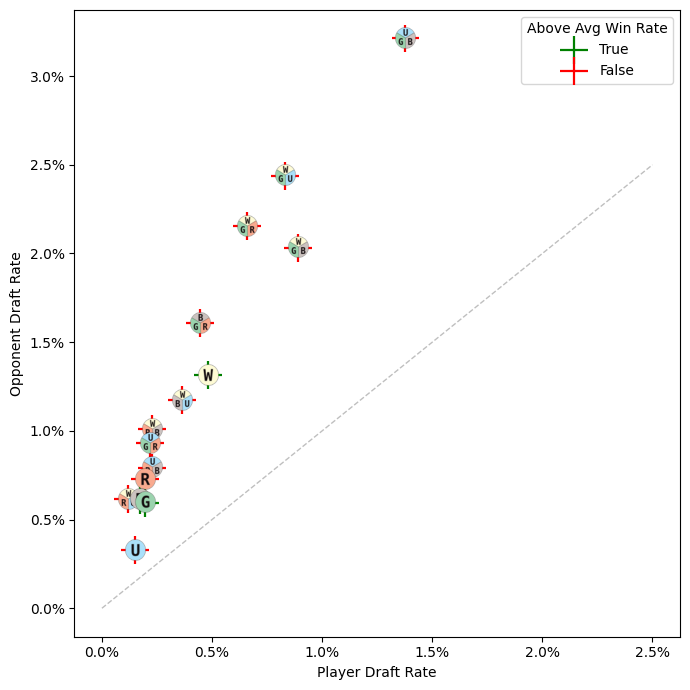

In [298]:
# | label: fig-player-vs-opp-freq-non-2color
# | fig-cap: "Use Rate of Players vs Opponents in 2-Color Draft Decks"

plt.figure(figsize=(7, 7))
g = sns.scatterplot(
    data=opp_colors_filtered,
    x="use_rate",
    y="opp_use_rate",
    hue="Above Avg Win Rate",
    marker="+",
    hue_order=[True, False],
    palette={True: "green", False: "red"},
    s=400,
)

plt.plot(
    [0.0, 0.025], [0.0, 0.025], color="gray", linestyle="--", linewidth=1, alpha=0.5
)

symbols.add_plot_symbols(
    data=opp_colors_filtered,
    x_col="use_rate",
    y_col="opp_use_rate",
    label_col="opp_colors",
    scale=0.04,
)

use_rate_mu = opp_colors_filtered["use_rate"].mean()
opp_use_rate_mu = opp_colors_filtered["opp_use_rate"].mean()

anno.set_labels_to_percent(axis="xy")
anno.set_axis_labels_and_show(xlabel="Player Draft Rate", ylabel="Opponent Draft Rate")

# Color Face-Offs (2-Color vs 2-Color)

Let's now see how each pairing of the two-color decks compare. This will give us insight into
strengths and weaknesses of individual decks.

First we will look at the number of games played between each pairing. The rows and columns are
sorted based on the maximum frequency of player deck pairings, with BG vs WG the most frequent,
followed by WG vs WG. The average number of games played between each pairing was 5,031.

As we saw above, the players use BG, WG, and UG more often than opponents,
with the other color pairs being used at near parity.


In [299]:
dual_colors = (
    df_draft.filter(
        pl.col("opp_colors").str.len_chars() == 2,
        pl.col("main_colors").str.len_chars() == 2,
        # pl.col("rank") == 'mythic',
    )
    .group_by(["opp_colors", "main_colors"])
    .agg(
        pl.col("n_games").sum(),
        pl.col("n_wins").sum(),
        pl.col("n_losses").sum(),
    )
    .sort(by="n_games", descending=True)
    .collect()
)
dual_colors = dual_colors.to_pandas()
dual_colors["win_rate"] = dual_colors["n_wins"] / dual_colors["n_games"]
dual_colors["loss_rate"] = dual_colors["n_losses"] / dual_colors["n_games"]
dual_colors = dual_colors.sort_values("win_rate", ascending=False).reset_index(
    drop=True
)

dual_matrix = dual_colors.pivot(
    index="main_colors", columns="opp_colors", values="n_games"
)

means = dual_matrix.max(axis=1).sort_values(ascending=False)
dual_matrix = dual_matrix.loc[means.index, means.index]
pair_mean = dual_matrix.mean().mean()

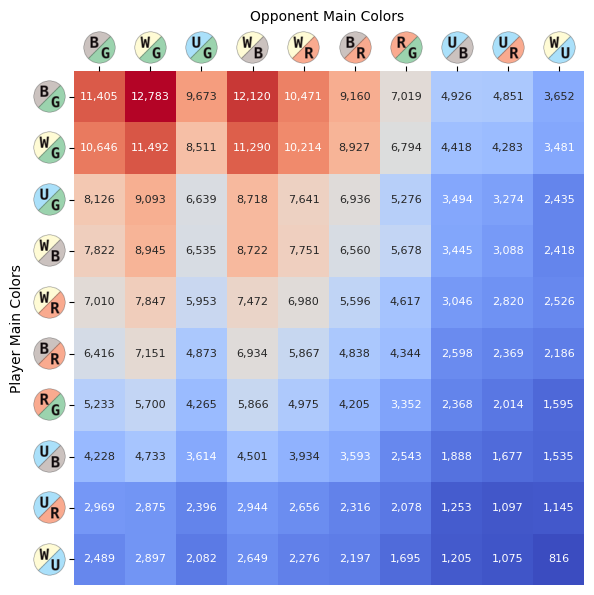

In [300]:
# | label: fig-player-vs-opp-2color-freq-heat
# | fig-cap: "Use Rate of Players vs Opponents in 2-Color Draft Decks"

plt.figure(figsize=(6, 6))
sns.heatmap(
    dual_matrix,
    annot=True,
    fmt=",.0f",
    cmap="coolwarm",
    cbar=False,
    annot_kws={"fontsize": 8},
)

symbols.add_heatmap_symbols()
anno.set_axis_labels_and_show(
    xlabel="Opponent Main Colors ", ylabel="Player Main Colors"
)

Next we look at the pair-wise win rates for players.

The most interesting observation is that the 17Lands player base is strong in most matchups, with
a large exception for the UR deck. On average, the UR matchups under-perform by ~4 percentage points
versus similar matchups. The UR-UR matchup is extremely low, and is the only like-paired matchup
that has lower than even odds of winning.


In [301]:
dual_matrix = dual_colors.pivot(
    index="main_colors", columns="opp_colors", values="win_rate"
)

dual_matrix = dual_matrix.loc[means.index, means.index]

pair_mean = dual_matrix.mean().mean()

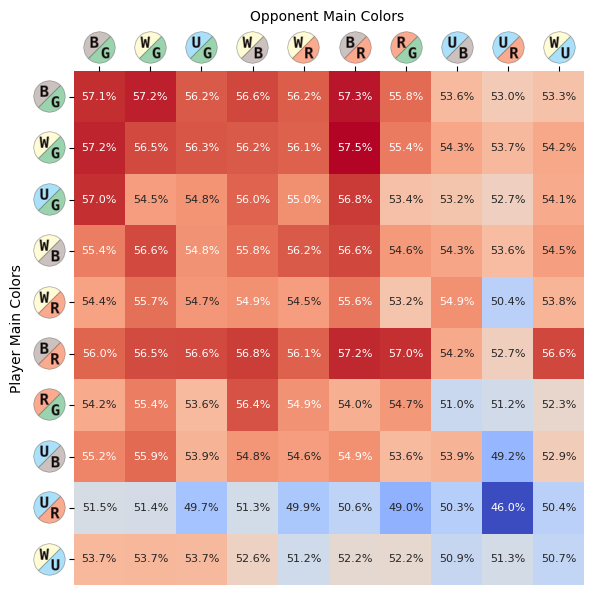

In [302]:
# | label: fig-player-vs-opp-2color-wins-heat
# | fig-cap: "Win Rate of Players vs Opponents in 2-Color Draft Decks"

plt.figure(figsize=(6, 6))
sns.heatmap(
    dual_matrix,
    annot=True,
    fmt=".1%",
    cmap="coolwarm",
    cbar=False,
    annot_kws={"fontsize": 8},
)

symbols.add_heatmap_symbols()
anno.set_axis_labels_and_show(
    xlabel="Opponent Main Colors ", ylabel="Player Main Colors"
)

# Color Splash

Splash colors are 1-3 non-land spell cards of a given color that spice up a deck without diluting
the main colors in the deck. They are often very powerful cards.

In the below plot, we see how often splashing occurs.


In [303]:
splash = (
    df_draft.group_by("splash_colors")
    .agg(
        pl.col("n_games").count().alias("len"),
        pl.col("n_wins").sum(),
        pl.col("n_games").sum(),
    )
    .sort(by="len", descending=True)
    .collect()
    .to_pandas()
)

splash["splash_colors"] = splash["splash_colors"].fillna("")
splash["Number of Splash Colors"] = splash["splash_colors"].str.len()
splash["splash_colors"] = splash["splash_colors"].replace({"": "None"})
splash["pct_splash"] = splash["len"] / splash["len"].sum()
splash = splash.sort_values(["Number of Splash Colors", "len"], ascending=[True, False])

splash_ct = (
    splash.groupby("Number of Splash Colors")
    .sum()
    .reset_index(drop=False)
    .sort_values(["Number of Splash Colors"], ascending=[True])
)

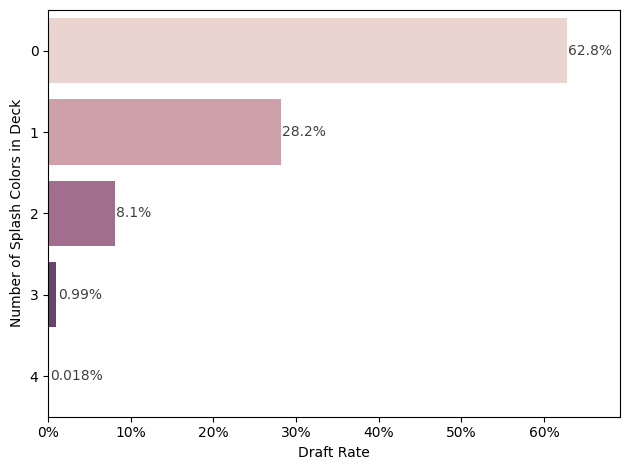

In [304]:
# | label: fig-n-color-splash-freq
# | fig-cap: "The frequency of splash colors."

g = sns.barplot(
    data=splash_ct,
    x="pct_splash",
    y="Number of Splash Colors",
    hue="Number of Splash Colors",
    orient="h",
    legend=False,
)

anno.annotate_bars()
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(
    xlabel="Draft Rate", ylabel="Number of Splash Colors in Deck"
)

In [305]:
splash_1 = splash.loc[splash["Number of Splash Colors"] == 1]

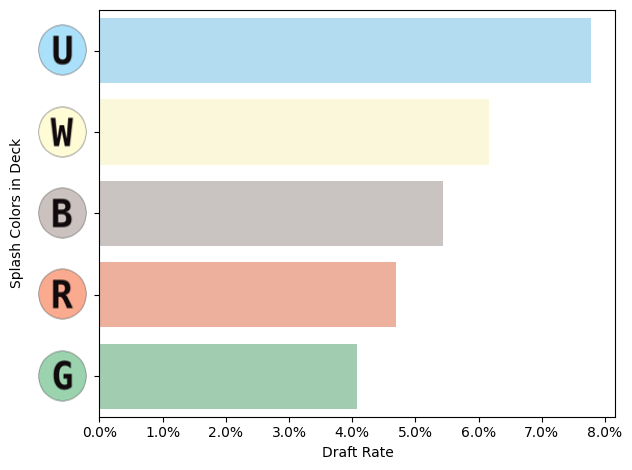

In [306]:
# | label: fig-component-splash-freq
# | fig-cap: "The rate at which the drafted deck contains a given splash color."

g = sns.barplot(
    data=splash_1,
    x="pct_splash",
    y="splash_colors",
    hue="splash_colors",
    palette=color_palette,
)

symbols.add_tick_symbols()
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(xlabel="Draft Rate", ylabel="Splash Colors in Deck")

# Player Rank


To get a sense of player skill, below I plotted the number of wins by the player rank. I do not
have player IDs, so I cannot track individual player performance. However, we can see the average
performance of the player base. I also cannot track the number of drafts per player, so more
frequent players will be over-represented.

While we do not have opponent rankings, we can infer that most opponents will be of the same rank
as the player. This is because the Arena draft system matches players with similar records. Each
ranked season is about 1 month long. Ranks have "rank decay" between seasons, meaning an the start
of the next season, a players rank will be lower than the previous season, requiring them to play
more games to get back to their previous rank.

So our snapshot of each rank is a mix of lower-skill, end-of-season players at their peak, and
higher-skill, start-of-season players who are climbing back up the ranks.


Below we see that most drafts are played by players in the Platinum ranks.


In [307]:
draft_rank = (
    df_draft.group_by("rank")
    .agg(
        pl.col("n_wins").len().alias("len"),
        pl.col("n_wins").sum(),
        pl.col("n_games").sum(),
    )
    .sort(by="n_wins", descending=True)
)

ordered_ranks = {
    0: "bronze",
    1: "silver",
    2: "gold",
    3: "platinum",
    4: "diamond",
    5: "mythic",
}

ordered_ranks_df = pl.LazyFrame(
    {"rank_value": list(ordered_ranks.keys()), "rank": list(ordered_ranks.values())}
).with_columns(
    # Create the rank_name column
    (pl.col("rank_value").cast(str) + " " + pl.col("rank").str.to_uppercase()).alias(
        "rank_name"
    )
)

ranks = (
    ordered_ranks_df.join(draft_rank, on="rank", how="left")
    .sort("rank_value")
    .collect()  # Execute the lazy frame
).to_pandas()

ranks["win_rate"] = ranks["n_wins"] / ranks["n_games"]

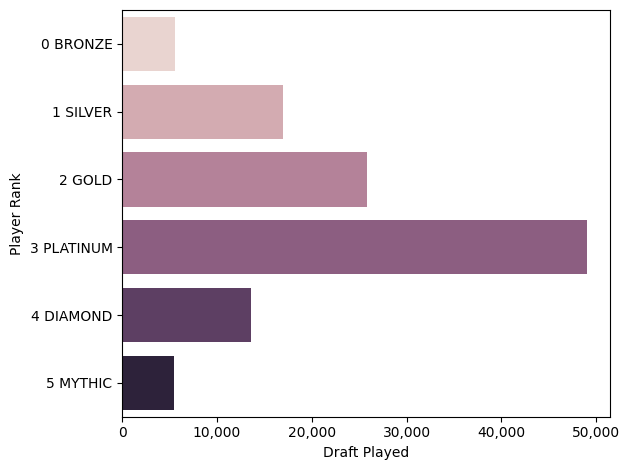

In [308]:
# | label: fig-rank-games
# | fig-cap: "Drafts Played by Players of Different Ranks."

sns.barplot(data=ranks, y="rank_name", x="len", hue="rank_value", legend=False)
anno.set_labels_to_commas()
anno.set_axis_labels_and_show(xlabel="Draft Played", ylabel="Player Rank")

Here we see that the win rates vary by rank. The higher ranks have higher win rates. Bronze has
by far the lowest win rate, indicating new or unskilled players. The Silver rank has the highest
win rate. This may be from the large number of Gold and Platinum players that reset to Silver at
the start of the season and quickly climb back up the ranks.


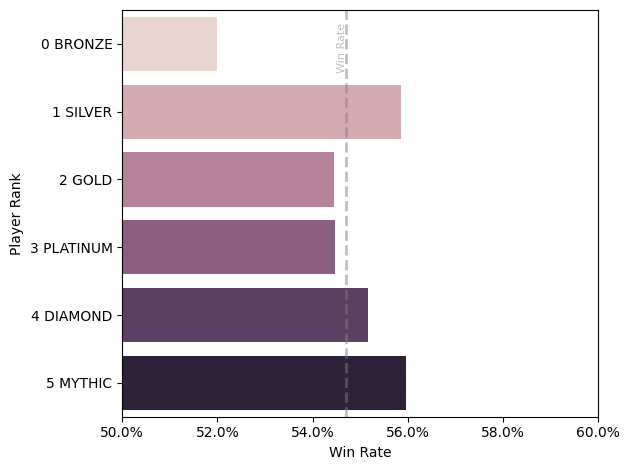

In [309]:
# | label: fig-ranks-win-rate
# | fig-cap: "Win Rate by Players of Different Ranks."

g = sns.barplot(data=ranks, y="rank_name", x="win_rate", hue="rank_value", legend=False)
g.set(xlim=(0.5, 0.60))

anno.plot_vert_line(x=mean_win_rate, label="Win Rate", y_pos=0.01, offset=-0.01)
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(xlabel="Win Rate", ylabel="Player Rank")

In [310]:
draft_rank = (
    df_draft.with_columns(
        (pl.col("draft_time") > pd.to_datetime("2024-08-13")).alias("last_week")
    )
    .group_by(["rank", "last_week"])
    .agg(
        pl.col("n_wins").len().alias("len"),
        pl.col("n_wins").sum(),
        pl.col("n_games").sum(),
    )
    .sort(by="n_wins", descending=True)
)


week_ranks = (
    ordered_ranks_df.join(draft_rank, on="rank", how="left")
    .sort("rank_value")
    .collect()  # Execute the lazy frame
).to_pandas()

week_ranks["win_rate"] = week_ranks["n_wins"] / week_ranks["n_games"]

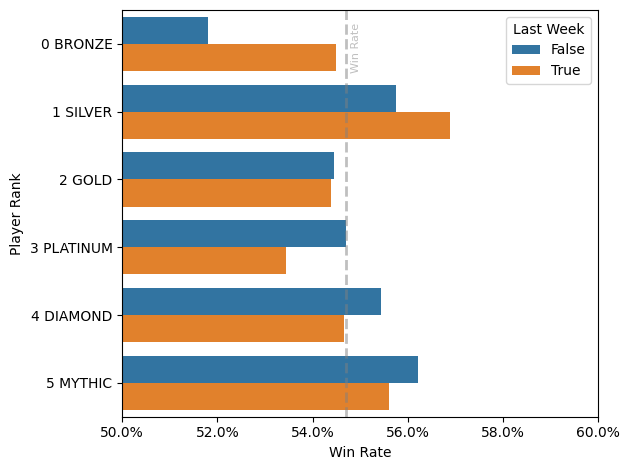

In [311]:
# | label: fig-ranked-win-rate-over-time
# | fig-cap: "Win Rate by Players of Different Ranks by Timeframe."

g = sns.barplot(data=week_ranks, y="rank_name", x="win_rate", hue="last_week")
g.set(xlim=(0.5, 0.60))

anno.plot_vert_line(x=mean_win_rate, label="Win Rate", y_pos=0.01, offset=0.02)
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(
    xlabel="Win Rate",
    ylabel="Player Rank",
    legend=True,
    legend_title="Last Week",
)

Below is a view for the number of games played per draft for each rank. While not identical,
the pattern is very similar to the above chart of win rate.


In [312]:
ranks["games_per_draft"] = ranks["n_games"] / ranks["len"]
mean_games_played = df_draft.select(pl.col("n_games").mean()).collect().to_numpy()[0][0]

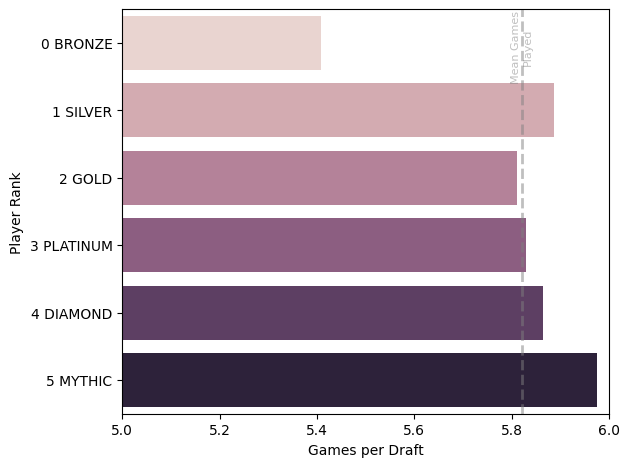

In [313]:
# | label: fig-ranked-n-games
# | fig-cap: "Games Played per Draft by Players of Different Ranks."

g = sns.barplot(
    data=ranks, y="rank_name", x="games_per_draft", hue="rank_value", legend=False
)
g.set(xlim=(5, 6))

anno.plot_vert_line(
    x=mean_games_played, label="Mean Games\nPlayed", y_pos=0.01, offset=0.0
)
anno.set_axis_labels_and_show(xlabel="Games per Draft", ylabel="Player Rank")

## Ranks over Time


We next look at the number of drafts played for each rank over the dataset. Since the BLB set was
released two days before the season start, I have truncated the data at 08-01 to avoid the rank
decay.

The first few days are chaotic, as the BLB set released on 07-30, but with 07-31 being the first
full day with games recorded. 08-01 was when the next ranked season started, resulting in rank
decay, which is especially pronounced in Mythic and Diamond gameplay.

An interesting pattern is seen starting on 08-01, with Gold quickly decaying after the initial peak of 3800 drafts per day.
The Platinum rank having a quick peak during days 4-6, then dropping.  
The Diamond rank has a slow climb with a plateau during days 8-13 and then slowly retracing.  
The Mythic rank starts at zero, then very slowly climbs te a peak of 500 drafts per day peak at 13-16 days.

From this chart, we can't tell how much of the decline at each ranks is due to player advancement, and how
much is loss of interest after the initial excitement of a new season. In the following charts,
I will normalize to the total drafts played to better account for overall decrease in gameplay.


In [314]:
rank_time_df = (
    df_draft.group_by(
        pl.col("draft_time").dt.truncate("1d")  # Truncate datetime to day
    )
    .agg(
        [
            pl.col("rank")
            .value_counts()
            .alias("rank_counts")  # Count occurrences of each rank
        ]
    )
    .explode("rank_counts")
    .with_columns(
        # Extract rank and count from the exploded struct
        pl.col("rank_counts").struct.field("rank").alias("rank"),
        pl.col("rank_counts").struct.field("count").alias("count"),
    )
    .drop("rank_counts")
    .join(ordered_ranks_df, on="rank", how="left")
    .sort(by=["draft_time", "rank_name"], descending=False)
    .collect()
    .to_pandas()
)

In [315]:
print(
    f"Total Time Interval: {(rank_time_df['draft_time'].max() - rank_time_df['draft_time'].min())}"
)

Total Time Interval: 19 days 00:00:00


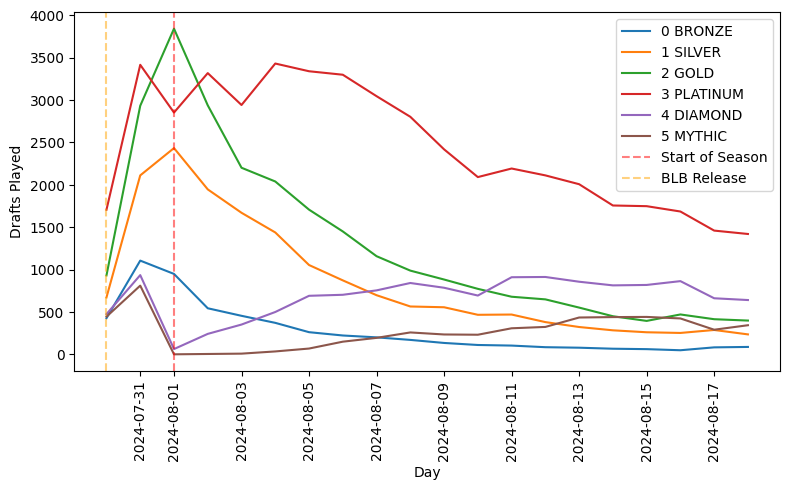

In [316]:
# | label: fig-ranked-drafts-over-time
# | fig-cap: "Drafts Played by Players Over Time, by Player rank."

plt.figure(figsize=(8, 5))
sns.lineplot(data=rank_time_df, x="draft_time", y="count", hue="rank_name")

plt.axvline(
    x=pd.to_datetime("2024-08-01"),
    color="red",
    linestyle="--",
    label="Start of Season",
    alpha=0.5,
)
plt.axvline(
    x=pd.to_datetime("2024-07-30"),
    color="orange",
    linestyle="--",
    label="BLB Release",
    alpha=0.5,
)
anno.set_axis_labels_and_show(
    xlabel="Day", ylabel="Drafts Played", legend=True, rot_x=True
)

Here we can see the numbers of drafts played. It is interesting that since both the release of BLB
and the start of the new season coincided, the player interest in draft was very high with a peak
of 11,300 drafts played on 07-31. The rate of play decayed over the weeks, with the minimum recorded
of 3,100 occurring on 08-17.

The decline is nearly monotonic, with slight upticks occurring on
the Saturdays of 08-04 and 08-11. This shows that the weekly seasonality is of minor effect.

It is interesting how releasing new sets increases player engagement. The introduction of the
new season on 08-01 doesn't seem to have caused an uptick in play, but this is a weak inference.  
From this data, I understand the economic motivation for releasing new sets for digital
engagement on Arena. One could infer that paper play would follow a similar pattern, with draft
play consuming many more booster packs a few weeks after a launch of a new set.

It would be interesting to compare this curve across set releases to get an indication of set-by-set
preferences of the player base.


In [317]:
rank_time_sum = (
    rank_time_df[["draft_time", "count"]].groupby(["draft_time"]).sum().reset_index()
)

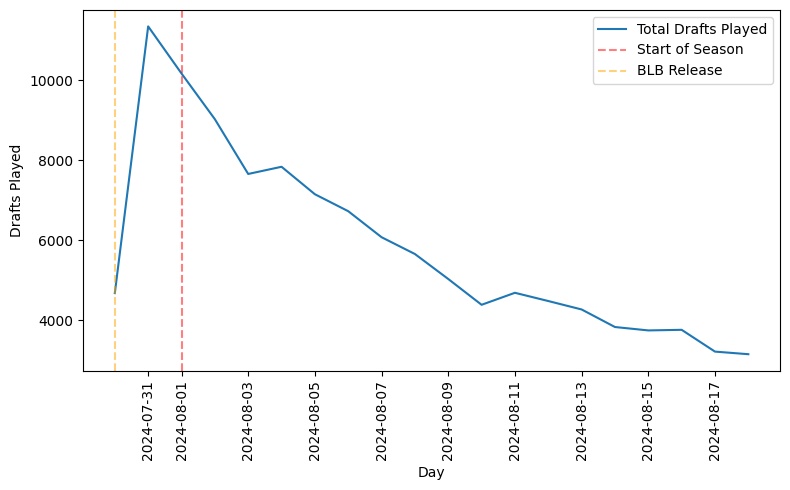

In [318]:
# | label: fig-ranked-total-drafts-over-time
# | fig-cap: "Total Drafts Played by Players Over Time."

plt.figure(figsize=(8, 5))
sns.lineplot(data=rank_time_sum, x="draft_time", y="count", label="Total Drafts Played")

plt.xlim = (pd.to_datetime("2024-07-29"), rank_time_sum["draft_time"].max())
plt.ylim = (0, 12000)

plt.axvline(
    x=pd.to_datetime("2024-08-01"),
    color="red",
    linestyle="--",
    label="Start of Season",
    alpha=0.5,
)
plt.axvline(
    x=pd.to_datetime("2024-07-30"),
    color="orange",
    linestyle="--",
    label="BLB Release",
    alpha=0.5,
)

anno.set_axis_labels_and_show(
    xlabel="Day", ylabel="Drafts Played", legend=True, rot_x=True
)

Next we normalize for the total games played to see relative ranked play across the player base.

We can now see the relative rank play much more clearly.  
After the new season start, Gold shows a linear decay as the player base advances to Platinum.  
The Platinum has a much more prolonged plateau, showing an equilibrium of new players joining the
rank versus existing players advancing.  
Both Diamond and Mythic start with minimal players, but gradually increase in play nearly monotonically
at differing rates.


In [319]:
rank_time_df2 = rank_time_df.merge(
    rank_time_sum, on="draft_time", suffixes=("", "_sum")
)
rank_time_df2["rank_pct"] = rank_time_df2["count"] / rank_time_df2["count_sum"]

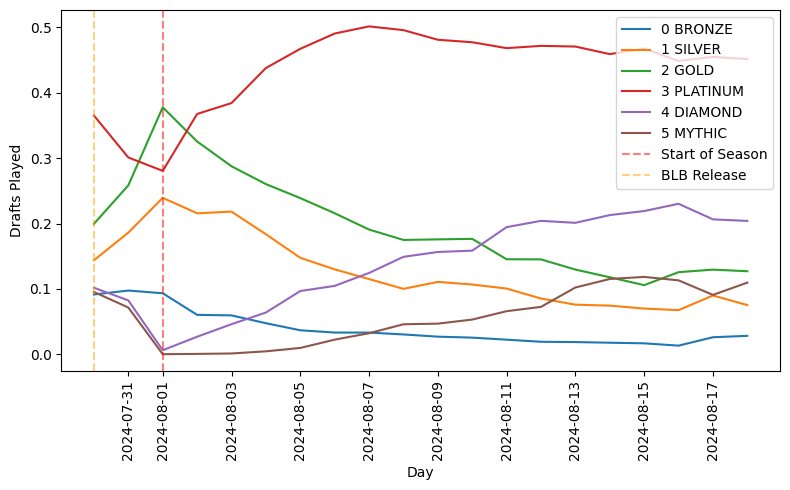

In [320]:
# | label: fig-normalized-ranked-drafts-over-time
# | fig-cap: "Normalized Drafts Played by Players of Different Ranks Over Time."

plt.figure(figsize=(8, 5))
sns.lineplot(data=rank_time_df2, x="draft_time", y="rank_pct", hue="rank_name")

plt.xlim = (pd.to_datetime("2024-07-29"), rank_time_sum["draft_time"].max())
plt.axvline(
    x=pd.to_datetime("2024-08-01"),
    color="red",
    linestyle="--",
    label="Start of Season",
    alpha=0.5,
)
plt.axvline(
    x=pd.to_datetime("2024-07-30"),
    color="orange",
    linestyle="--",
    label="BLB Release",
    alpha=0.5,
)

anno.set_axis_labels_and_show(
    xlabel="Day", ylabel="Drafts Played", legend=True, rot_x=True
)

## Low vs High Rank Players

Now let's compare the performance of player rank versus success. I will take the 3 two-color decks
that were outliers in the previous use-rate versus win-rate chart. I'll use the BG deck with a high
use and win rate, the BR deck with a high win rate and lower use rate, and the UR deck, with the
very low use rate and an extremely low win rate.

Below we can see the overall performance of players with these decks. We have two categories. The
first is the week of play and the second is the if the player is in the elite ranks of Diamond or
Mythic.

For BG, the most played deck, the performance across weeks and ranks shows no clear trend.  
However, the BR and UR decks, which are less played, both sets of ranked players showed noticeable
gains in win rate from week one to two. This indicates that the 17Lands player base learned how to better
use these less favorable decks, regardless of rank.

Note that for the first week of play, the Mythic and Diamond play base is very small.


In [321]:
draft_rank_deck = (
    df_draft.with_columns(
        (
            (
                (pl.col("draft_time") - pd.to_datetime("2024-07-30"))
                / pd.Timedelta(days=7)
            ).cast(pl.Int64)
        ).alias("week"),
        (pl.col("rank").is_in(["mythic", "diamond"])).alias("elite_ranks"),
    )
    .filter(
        pl.col("main_colors").is_in(["BG", "BR", "UR"]),
    )
    .group_by(["rank", "main_colors", "week"])
    .agg(
        pl.col("n_wins").len().alias("len"),
        pl.col("n_wins").sum(),
        pl.col("n_games").sum(),
        pl.col("elite_ranks").first(),
    )
    .sort(by="n_wins", descending=True)
)

ranks_deck = (
    ordered_ranks_df.join(draft_rank_deck, on="rank", how="left")
    .sort("rank_value")
    .collect()  # Execute the lazy frame
).to_pandas()
ranks_deck["win_rate"] = ranks_deck["n_wins"] / ranks_deck["n_games"]

ranks_deck = ranks_deck.rename(
    columns={
        "elite_ranks": "Rank of Mythic or Diamond",
        "week": "Week of Play",
        "main_colors": "Player Deck Colors",
        "win_rate": "Player Win Rate",
    }
)

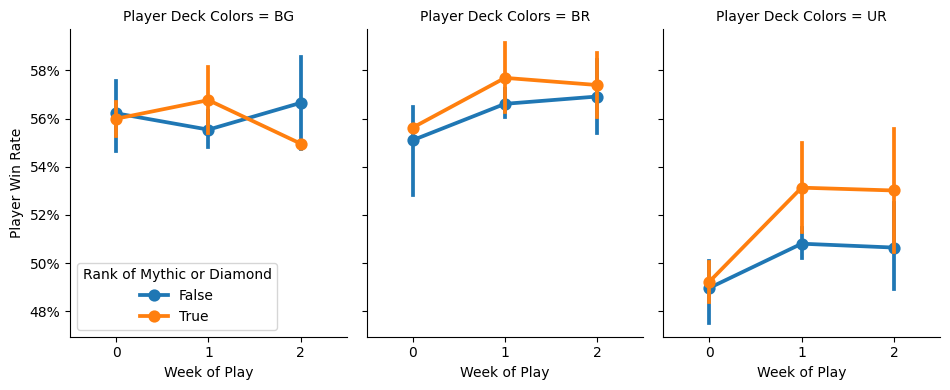

In [322]:
# | label: fig-top-decks-by-rank
# | fig-cap: "Win Rate for given color decks for top-ranked players vs others."

sns.catplot(
    data=ranks_deck,
    x="Week of Play",
    y="Player Win Rate",
    hue="Rank of Mythic or Diamond",
    kind="point",
    col="Player Deck Colors",
    height=4,
    aspect=0.8,
    legend_out=False,
)

anno.set_labels_to_percent(axis="y")
anno.set_axis_labels_and_show()

# Mulligans


Mulligans are a key strategy in MTG. If a player starting hand is not good, they draw a new one, with one less card. This can be repeated as needed, with one less card each time. Evaluating the trade-off between a bad hand and a smaller hand is not trivial.

Below we see the distribution of mulligans by number of re-draws. Most players do not take a mulligan. About 12% of players take one mulligan, and 2% take two mulligans. The number of players taking three or more mulligans is very low. There are two instances of a player taking 5 mulligans, which would have had a starting hand of two cards.

We can also see that 17Lands players are slightly less likely to take mulligans than their opponents. This may be due to a combination of better deck construction and better mulligan decisions.


In [323]:
df_games = pl.scan_parquet(game_file)

sum_df = df_summary.collect().to_pandas()
mean_mulligan_rate = (sum_df["n_mul"] / sum_df["n_games"]).values[0]

df_mul = df_games.unpivot(
    index=["num_mulligans"],
    on=["num_mulligans", "opp_num_mulligans"],
    variable_name="Player",
    value_name="mulligan_count",
)


df_mul2 = df_mul.collect().to_pandas()

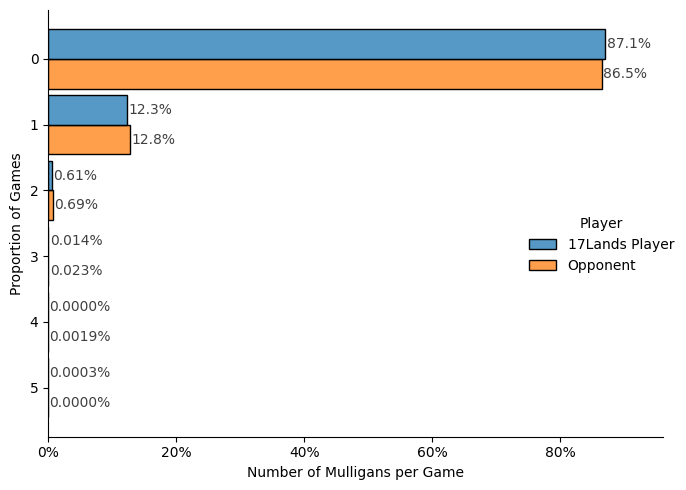

In [324]:
# | label: fig-mulligan-distro
# | fig-cap: "Distribution of Mulligans."


g = sns.displot(
    data=df_mul2,
    y="mulligan_count",
    hue="Player",
    multiple="dodge",
    stat="proportion",
    common_norm=False,
    discrete=True,
    shrink=0.9,
    element="bars",
)

anno.set_labels_to_percent()
anno.annotate_bars()
anno.set_axis_labels_and_show(
    xlabel="Number of Mulligans per Game",
    ylabel="Proportion of Games",
    reverse_y=True,
    legend=g._legend,
    legend_labels={
        "num_mulligans": "17Lands Player",
        "opp_num_mulligans": "Opponent",
    },
)

A side note on probability distributions. The player distributions appear to me to be Poisson distributions, with the number of mulligans taken being a discrete event.

Using the mean number of mulligans per game of 0.136, I did a random samplings of a Poisson distribution with $\lambda=0.136$. The results are very similar to the actual data, with the actual data having a slightly higher number of 1 mulligan games and a slightly lower number of other values.

We can investigate this further when we explore the card data and see what types of random draw events correlate with mulligan decisions. An example would be number of lands in the starting hand.


In [325]:
n_games = df_games.collect().shape[0]

df_games = df_games.with_columns(
    pl.Series(np.random.poisson(lam=mean_mulligan_rate, size=n_games)).alias(
        "sampled_mul"
    )
)

df_mul_sample = df_games.unpivot(
    index=["draft_id"],
    on=["num_mulligans", "sampled_mul"],
    variable_name="Distribution",
    value_name="mulligan_count",
)


df_mul_sample = df_mul_sample.collect().to_pandas()

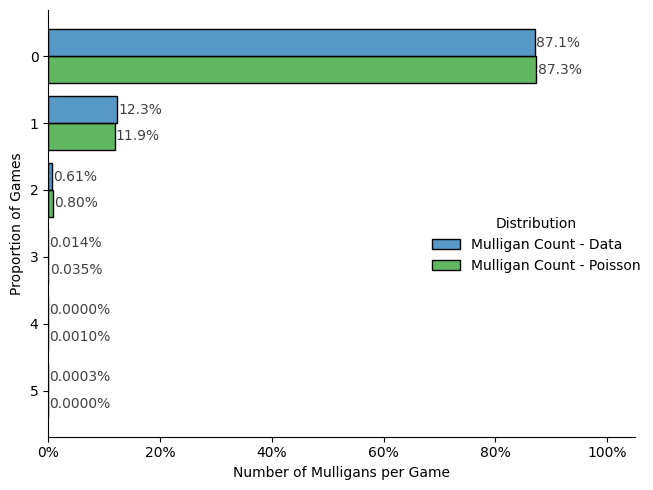

In [326]:
# | label: fig-mulligan-poisson
# | fig-cap: "Distribution of Player Mulligans vs Poisson Distribution."

custom_palette = {
    "num_mulligans": "#1f77b4",
    "sampled_mul": "#2ca02c",
}

g = sns.displot(
    data=df_mul_sample,
    y="mulligan_count",
    hue="Distribution",
    multiple="dodge",
    stat="proportion",
    common_norm=False,
    discrete=True,
    shrink=0.8,
    element="bars",
    palette=custom_palette,
)

g.set(xlim=(0, 1))
anno.set_labels_to_percent()
anno.annotate_bars()
anno.set_axis_labels_and_show(
    xlabel="Number of Mulligans per Game",
    ylabel="Proportion of Games",
    reverse_y=True,
    legend=g._legend,
    legend_labels={
        "num_mulligans": "Mulligan Count - Data",
        "sampled_mul": "Mulligan Count - Poisson",
    },
)

We now look at the outcomes of games where mulligans occur. After plotting the win rates at each mulligan value, it is very apparent the near linear relationship between mulligans and win rate. The win rate decreases by about 15% for each mulligan taken.

Comparing the 17Lands player their opponents, the win rate decay is consistent, with the gap between the two player bases being about 8-9% at each mulligan level.

With this data, we cannot decern the causal relationship between mulligans and win rates. Are mulligans always bad, or are they a sign of a bad hand that would have an even lower probability of winning. This is a question that can be answered with the card data.


In [327]:
df_mul_win = (
    df_games.group_by(["num_mulligans"])
    .agg(
        pl.col("won").count().alias("n_games"),
        pl.col("won").sum().alias("n_wins"),
        pl.col("won").mean().alias("win_rate"),
    )
    .with_columns((pl.col("n_games") / pl.col("n_games").sum()).alias("pct_games"))
    .sort(by="num_mulligans", descending=False)
    .collect()
).to_pandas()

df_mul_win_opp = (
    df_games.with_columns((1 - pl.col("won")).alias("opp_won"))
    .group_by(["opp_num_mulligans"])
    .agg(
        pl.col("opp_won").count().alias("n_games"),
        pl.col("opp_won").sum().alias("n_wins"),
        pl.col("opp_won").mean().alias("win_rate"),
    )
    .with_columns((pl.col("n_games") / pl.col("n_games").sum()).alias("pct_games"))
    .sort(by="opp_num_mulligans", descending=False)
    .collect()
).to_pandas()

df_mul_win = df_mul_win.merge(
    df_mul_win_opp,
    left_on="num_mulligans",
    right_on="opp_num_mulligans",
    suffixes=("", "_opp"),
)

df_mul_win_m = df_mul_win.melt(
    id_vars=["num_mulligans"],
    value_vars=["win_rate", "win_rate_opp"],
    var_name="Player",
    value_name="Win Rate",
)

df_mul_win_m["Player"].replace(
    {"win_rate": "Player Win Rate", "win_rate_opp": "Opponent Win Rate"}, inplace=True
)

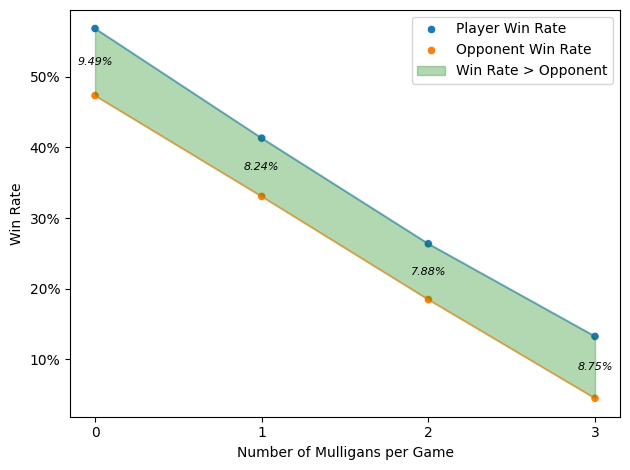

In [328]:
# | label: fig-player-vs-opponent-mulligan-wins
# | fig-cap: "Win Rates for Players and Opponents by Mulligans."

sns.scatterplot(data=df_mul_win_m, x="num_mulligans", y="Win Rate", hue="Player")
sns.lineplot(
    data=df_mul_win_m,
    x="num_mulligans",
    y="Win Rate",
    hue="Player",
    legend=False,
    alpha=0.5,
)

plt.fill_between(
    df_mul_win["num_mulligans"],
    df_mul_win["win_rate"],
    df_mul_win["win_rate_opp"],
    where=(df_mul_win["win_rate"] > df_mul_win["win_rate_opp"]),
    interpolate=True,
    color="green",
    alpha=0.3,
    label="Win Rate > Opponent",
)

for i, (x, y1, y2) in enumerate(
    zip(df_mul_win["num_mulligans"], df_mul_win["win_rate"], df_mul_win["win_rate_opp"])
):
    plt.text(
        x,
        (y1 + y2) / 2,
        f"{(y1 - y2):.2%}",
        ha="center",
        va="center",
        fontsize=8,
        fontstyle="italic",
    )

plt.ylim = (0, 0.6)
anno.set_labels_to_percent(axis="y")
anno.set_labels_to_ints(axis="x")
anno.set_axis_labels_and_show(
    xlabel="Number of Mulligans per Game",
    ylabel="Win Rate",
    legend=True,
)

To see if there is appreciable difference between mulligan success and player rank, I plotted the win rates for each rank. The win rates are very similar across ranks, with no appreciable differences.


In [329]:
ranks = ["gold", "platinum", "diamond", "mythic"]

df_mul_win = (
    df_games.filter(pl.col("rank").is_in(ranks))
    .group_by(["num_mulligans", "rank"])
    .agg(
        pl.col("won").count().alias("n_games"),
        pl.col("won").sum().alias("n_wins"),
        pl.col("won").mean().alias("win_rate"),
    )
    .with_columns((pl.col("n_games") / pl.col("n_games").sum()).alias("pct_games"))
    .sort(by="num_mulligans", descending=False)
    .filter(
        pl.col("num_mulligans") < 3,
    )
    .collect()
).to_pandas()

df_mul_win["rank"].replace({rank: rank.title() for rank in ranks}, inplace=True)

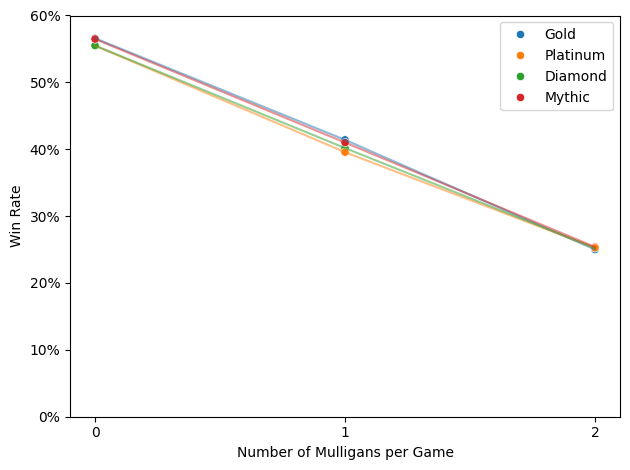

In [330]:
# | label: fig-mulligan-win-rate-by-rank
# | fig-cap: "Win Rates of Mulligans by Player Rank."

g = sns.scatterplot(
    data=df_mul_win,
    x="num_mulligans",
    y="win_rate",
    hue="rank",
    hue_order=[rank.title() for rank in ranks],
)
g = sns.lineplot(
    data=df_mul_win,
    x="num_mulligans",
    y="win_rate",
    hue="rank",
    hue_order=[rank.title() for rank in ranks],
    legend=False,
    alpha=0.5,
)

g.set(ylim=(0, 0.6))
anno.set_labels_to_percent(axis="y")
anno.set_labels_to_ints(axis="x")
anno.set_axis_labels_and_show(
    xlabel="Number of Mulligans per Game",
    ylabel="Win Rate",
    legend=True,
)

# Turn Counts (UPDATE ME)


# Builds (UPDATE ME)


# Starting Player (UPDATE ME)
